# One Step Diffusion via Shortcut Models

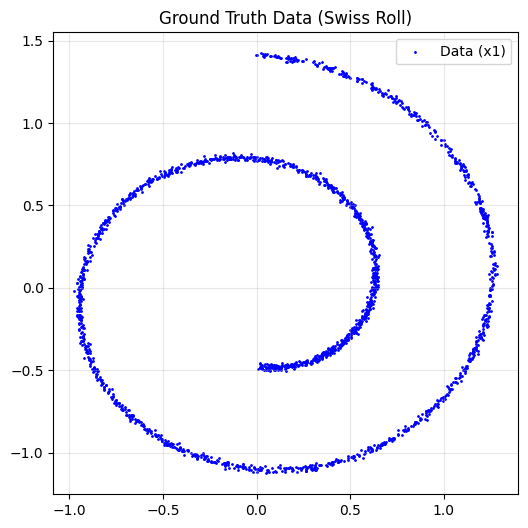

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

torch.manual_seed(42)
np.random.seed(42)

# Function to generate Swiss Roll data
def get_data(n_samples=2000):
    data, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)
    data = data[:, [0, 2]] / 10.0  # Normalize to reasonable range [-1.5, 1.5]
    return torch.from_numpy(data).float()

data = get_data()
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=1, color='blue', label='Data (x1)')
plt.title("Ground Truth Data (Swiss Roll)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
# Model Definition

class ShortcutMLP(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # Input: x(2) + t(1) + d(1) = 4 dimensions
        self.net = nn.Sequential(
            nn.Linear(4, hidden_dim),
            nn.Tanh(),              
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2) 
        )

    def forward(self, x, t, d):
        if t.dim() == 1: t = t.unsqueeze(-1)
        if d.dim() == 1: d = d.unsqueeze(-1)
        
        inp = torch.cat([x, t, d], dim=-1)
        return self.net(inp)

Step 0, Loss: 1.4554
Step 1000, Loss: 0.8520
Step 2000, Loss: 0.8372
Step 3000, Loss: 1.0697
Step 4000, Loss: 1.0055


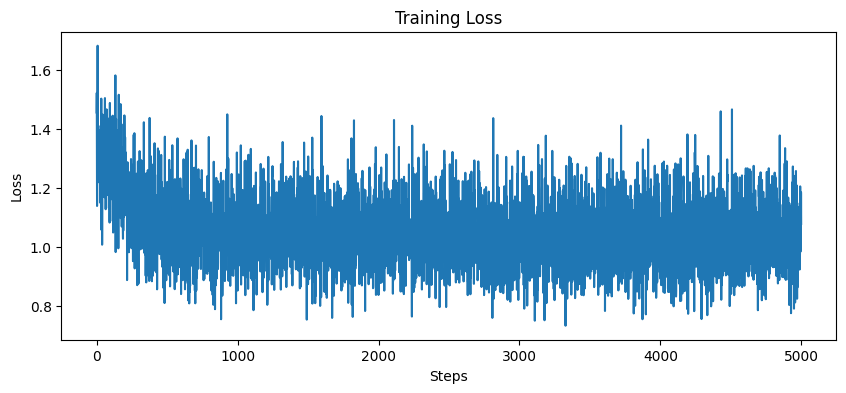

In [3]:
# Training Loop

def train_shortcut_model(steps=5000, batch_size=128):
    model = ShortcutMLP()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    
    for step in range(steps):
        # Get Real Data (x1) and Noise (x0)
        x1 = get_data(batch_size)
        x0 = torch.randn_like(x1) # Gaussian Noise
        
        # Sample t and interpolate xt
        t = torch.rand(batch_size, 1)
        xt = (1 - t) * x0 + t * x1
        
        optimizer.zero_grad()
        
        # 75% Flow Matching (d=0), 25% Self-Consistency (d>0)
        split = int(batch_size * 0.75)
        
        # Flow Matching (d=0), target: v = x1 - x0
        d_zero = torch.zeros(split, 1)
        pred_flow = model(xt[:split], t[:split], d_zero)
        target_flow = x1[:split] - x0[:split]
        loss_fm = F.mse_loss(pred_flow, target_flow)
        
        # Self-Consistency (d>0)
        x_sc = xt[split:]
        t_sc = t[split:]
        
        # Sample random step size d from discrete powers of 2
        M = 16 
        k = torch.randint(0, int(np.log2(M)), (batch_size - split, 1))
        d_val = (2.0 ** k) / M
        
        # Ensure we don't step past t=1
        mask = (t_sc + 2 * d_val) <= 1.0
        
        loss_sc = torch.tensor(0.0)
        if mask.sum() > 0:
            x_curr = x_sc[mask.squeeze()]
            t_curr = t_sc[mask.squeeze()]
            d_curr = d_val[mask.squeeze()]
            
            # Predict small step s_t
            s1 = model(x_curr, t_curr, d_curr)
            
            # Euler integration
            x_mid = x_curr + s1 * d_curr
            t_mid = t_curr + d_curr
            
            # Predict next small step s_{t+d}
            with torch.no_grad():
                s2 = model(x_mid, t_mid, d_curr)
            
            # Target for large step 
            target_cons = (s1 + s2) / 2.0
            
            # Predict large step directly (size 2d)
            pred_cons = model(x_curr, t_curr, 2 * d_curr)
            
            loss_sc = F.mse_loss(pred_cons, target_cons)

        loss = loss_fm + loss_sc
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if step % 1000 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")
            
    return model, losses


model, loss_history = train_shortcut_model(steps=5000)
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

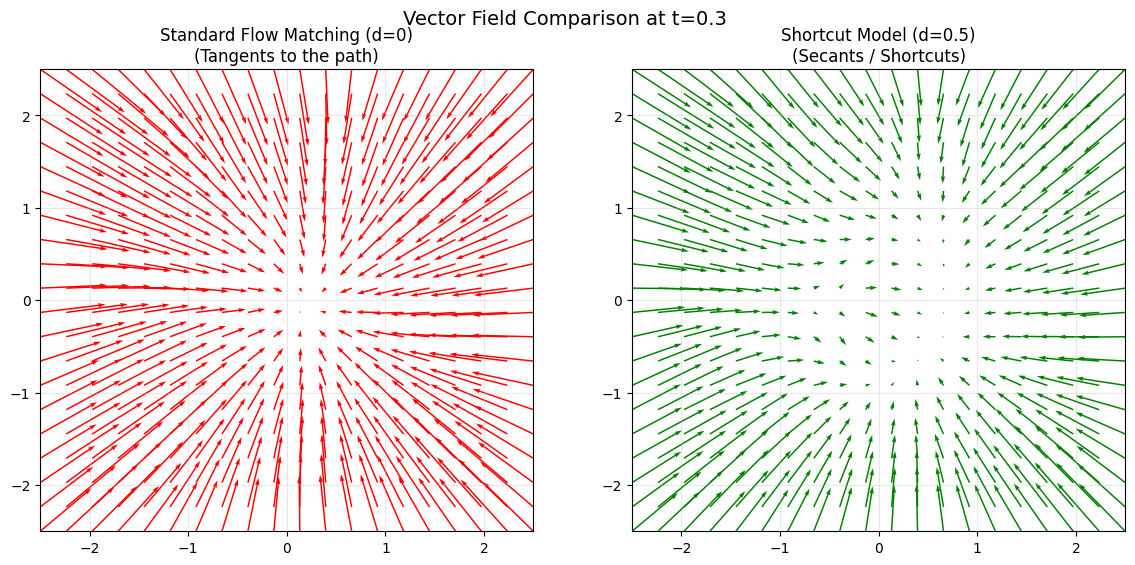

In [4]:
# Vizualization of Vector Fields

def plot_vector_field(model, t_val=0.5):
    """
    Visualizes the vector field at a specific time t.
    Compares d=0 (Tangent Flow) vs d=0.5 (Shortcut).
    """
    x = np.linspace(-2.5, 2.5, 20)
    y = np.linspace(-2.5, 2.5, 20)
    xx, yy = np.meshgrid(x, y)
    grid_tensor = torch.tensor(np.stack([xx, yy], axis=-1)).float().reshape(-1, 2)
    
    t_tensor = torch.ones(len(grid_tensor), 1) * t_val
    
    model.eval()
    with torch.no_grad():
        # 1. Flow Matching (d=0)
        d_zero = torch.zeros(len(grid_tensor), 1)
        vectors_flow = model(grid_tensor, t_tensor, d_zero).numpy()
        
        # 2. Shortcut (d=0.5) 
        d_large = torch.ones(len(grid_tensor), 1) * 0.5
        vectors_shortcut = model(grid_tensor, t_tensor, d_large).numpy()

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot A: Standard Flow (d=0)
    ax[0].quiver(grid_tensor[:,0], grid_tensor[:,1], 
                 vectors_flow[:,0], vectors_flow[:,1], 
                 color='red', scale=20)
    ax[0].set_title(f"Standard Flow Matching (d=0)\n(Tangents to the path)")
    ax[0].set_xlim(-2.5, 2.5); ax[0].set_ylim(-2.5, 2.5)
    ax[0].grid(True, alpha=0.3)

    # Plot B: Shortcut Model (d=0.5)
    ax[1].quiver(grid_tensor[:,0], grid_tensor[:,1], 
                 vectors_shortcut[:,0], vectors_shortcut[:,1], 
                 color='green', scale=20)
    ax[1].set_title(f"Shortcut Model (d=0.5)\n(Secants / Shortcuts)")
    ax[1].set_xlim(-2.5, 2.5); ax[1].set_ylim(-2.5, 2.5)
    ax[1].grid(True, alpha=0.3)
    
    plt.suptitle(f"Vector Field Comparison at t={t_val}", fontsize=14)
    plt.show()

plot_vector_field(model, t_val=0.3)

Running Robustness Evaluation...
Steps: 128 | Shortcut Err: 0.0305 | Standard Err: 0.0305
Steps:  64 | Shortcut Err: 0.0308 | Standard Err: 0.0301
Steps:  32 | Shortcut Err: 0.0302 | Standard Err: 0.0278
Steps:  16 | Shortcut Err: 0.0262 | Standard Err: 0.0322
Steps:   8 | Shortcut Err: 0.0318 | Standard Err: 0.0339
Steps:   4 | Shortcut Err: 0.0327 | Standard Err: 0.0385
Steps:   2 | Shortcut Err: 0.0320 | Standard Err: 0.0684
Steps:   1 | Shortcut Err: 0.0320 | Standard Err: 0.1264


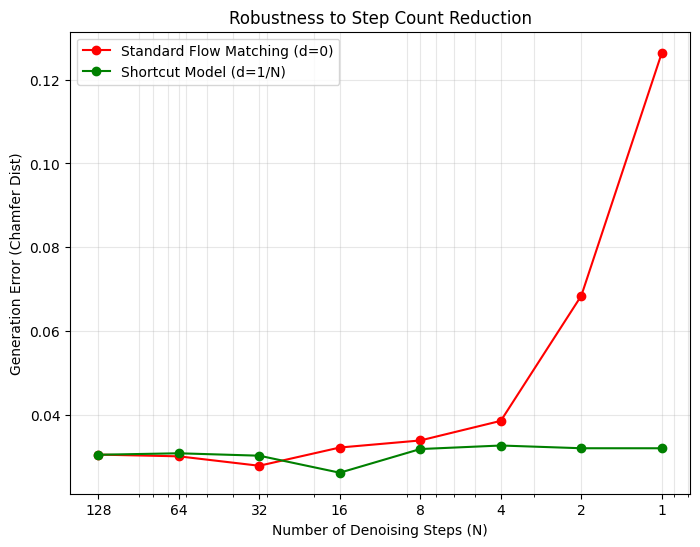

In [5]:
# Second experiment 

def compute_chamfer_error(gen_samples, real_samples):
    """
    Computes a simplified Chamfer Distance:
    Average distance from each generated point to its nearest real neighbor.
    """
    gen = gen_samples.unsqueeze(1) 
    real = real_samples.unsqueeze(0) 
    dists = torch.sum((gen - real) ** 2, dim=2) 
    min_dists, _ = torch.min(dists, dim=1) 
    return torch.mean(min_dists).item()

def sample(model, n_steps, use_shortcut=True, n_samples=500):
    """
    Generates samples using Euler integration.
    use_shortcut=True:  Queries model with d = step_size
    use_shortcut=False: Queries model with d = 0 (Simulates standard Flow Matching)
    """
    model.eval()
    with torch.no_grad():
        x = torch.randn(n_samples, 2)
        step_size = 1.0 / n_steps
        t = 0.0
        
        for _ in range(n_steps):
            t_tensor = torch.ones(n_samples, 1) * t
            
            if use_shortcut:
                d_tensor = torch.ones(n_samples, 1) * step_size
            else:
                d_tensor = torch.zeros(n_samples, 1) # Standard Flow behavior
                
            velocity = model(x, t_tensor, d_tensor)
            x = x + velocity * step_size
            t += step_size
            
    return x


step_counts = [128, 64, 32, 16, 8, 4, 2, 1]
errors_shortcut = []
errors_standard = []

real_data = get_data(500) 

print("Running Robustness Evaluation...")
for n in step_counts:
    # Evaluate Shortcut Mode (Uses d = 1/N)
    samples_s = sample(model, n, use_shortcut=True)
    err_s = compute_chamfer_error(samples_s, real_data)
    errors_shortcut.append(err_s)
    
    # Evaluate Standard Mode (Uses d = 0)
    samples_f = sample(model, n, use_shortcut=False)
    err_f = compute_chamfer_error(samples_f, real_data)
    errors_standard.append(err_f)
    
    print(f"Steps: {n:3d} | Shortcut Err: {err_s:.4f} | Standard Err: {err_f:.4f}")


plt.figure(figsize=(8, 6))
plt.plot(step_counts, errors_standard, 'r-o', label='Standard Flow Matching (d=0)')
plt.plot(step_counts, errors_shortcut, 'g-o', label='Shortcut Model (d=1/N)')
plt.xscale('log')
plt.gca().invert_xaxis() 
plt.xticks(step_counts, labels=step_counts)
plt.xlabel('Number of Denoising Steps (N)')
plt.ylabel('Generation Error (Chamfer Dist)')
plt.title('Robustness to Step Count Reduction')
plt.legend()
plt.grid(True, alpha=0.3, which="both")
plt.show()